# Partial Differential Equations solved using PINNs.


### 1. Defining a few functions and initial, boundaries, eqns and stuff.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn

### 1. Defining the initial arrays of space and time.

In [64]:
Nx = 20
Nt = 20
Nv = 20

k = 0.4
L = (2 * np.pi) / k

x = torch.linspace(0, L, Nx).view(-1, 1)  #[Nx]
v = torch.linspace(-6, 6, Nv).view(-1, 1) #[Nv]
t = torch.linspace(0, 25, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape} and v : {v.shape}")


Shape of x : torch.Size([20, 1]) and t : torch.Size([20, 1]) and v : torch.Size([20, 1])


In [65]:
# Meshes and vectors
X_train, v_train, t_train = torch.meshgrid(x.squeeze(), v.squeeze() ,t.squeeze(), indexing='xy')

X_train, v_train, t_train = X_train.reshape(-1, 1), v_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape} and v_train : {v_train.shape}")

Shape of X_train : torch.Size([8000, 1]) and t_train : torch.Size([8000, 1]) and v_train : torch.Size([8000, 1])


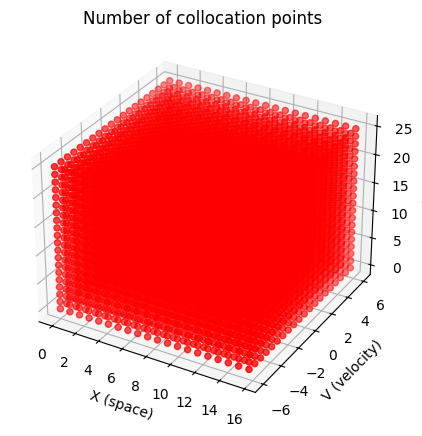

In [66]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train, v_train, t_train, c='r', marker='o')
ax.set_xlabel('X (space)')
ax.set_ylabel('V (velocity)')
ax.set_zlabel('T (time)')
ax.set_title('Number of collocation points')
plt.show()

### 2. Neural network architecture.

In [67]:
class PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.Tanh

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, v, t):
    inputs = torch.cat([x, v, t], dim=1)
    outputs = self.net(inputs)

    q = outputs[:, 0:1]
    E = outputs[:, 1:2]

    return q, E

### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [68]:
def pde_loss(q_pred, E_pred, x_train, v_train, t_train):
  """
  Vlassov : dQ_dt + (V * dQ_dx) + (a * dQ_dv) = 0
  Poisson : dE_dx - integral(Q, dv) + 1 = 0
  IC : Q(x, v, t=0) = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x)) | E(x, v, t=0) = (alpha/k) * torch.cos(k * x)
  BC : Q is period

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dv = torch.autograd.grad(q_pred, v_train, torch.ones_like(q_pred), create_graph=True)[0]
  dE_dx = torch.autograd.grad(E_pred, x_train, torch.ones_like(E_pred), create_graph=True)[0]

  #eqn1 = dQ_dt + (v * dQ_dx) + (E * dQ_dv)
  eqn1 = dQ_dt + (v_train * dQ_dx) - (E_pred * dQ_dv) #Vlassov


  q_copy = q_pred.view(Nx, Nv, Nt).detach() # [Nx, Nv, Nt]
  v_grid = v.view(1, Nv, 1).expand(Nx, Nv, Nt)  # [Nx, Nv, Nt]
  rho = torch.trapz(q_copy, v_grid, dim=1)
  rho = rho.unsqueeze(1).expand(-1, Nv, -1).reshape(-1, 1)

  eqn2 = dE_dx + (rho) - 1 #Poisson

  # print(integral)
  return torch.mean(eqn1**2) + torch.mean(eqn2**2)


def initial_condition_loss(q_pred, E_pred, x, v, t, alpha = 0.01):
  initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x))      #No use of v or t here, this is the initial condition.
  initial_condition_E = (alpha/k) * torch.cos(k * x)          #Again no use of v or t, this is the initial condition.

  return torch.mean((q_pred-initial_condition_Q) ** 2) + torch.mean((E_pred-initial_condition_E) ** 2)


def boundary_condition_loss(qlb_pred, qup_pred, elb_pred, eup_pred, t):
  lb, ub = torch.zeros_like(t), torch.zeros_like(t) # Lb = 0, Ub = 0. Both of the same shape as t.

  return torch.mean((qup_pred - qlb_pred) ** 2) + torch.mean((eup_pred-elb_pred) ** 2) # Periodic along x axis and v axis.

### 4. Writing the training loop.

In [69]:
model = PINN(3, 64, 4, 2)
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
epochs = 20

In [70]:
X_train_Vlasov = X_train.requires_grad_(True)
t_train_Vlasov = t_train.requires_grad_(True)
v_train_Vlasov = v_train.requires_grad_(True)

X_train_Poisson = X_train.requires_grad_(True)
t_train_Poisson = t_train.requires_grad_(True)

In [71]:
TOTAL_LOSS = []

for epoch in range(1, epochs+1):
  model.train()
  optimiser.zero_grad()

  # Initial Condition
  q_pred_init, e_pred_init = model(x, v, torch.zeros_like(x)) # q,E(x, v, 0)
  ic_loss = initial_condition_loss(q_pred_init, e_pred_init, x, v, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred, e_lb_pred = model(torch.full_like(t, 0), v, t) # q,E(0, v, t) - lower bound at x=0
  q_ub_pred, e_up_pred = model(torch.full_like(t, L), v, t) # q,E(16, v, t) - upper bound at x=16
  bcloss1 = boundary_condition_loss(q_lb_pred, q_ub_pred, e_lb_pred, e_up_pred, t)

  q_lb_pred, e_lb_pred = model(x, torch.full_like(t, -6), t) # q,E(x, -6, t) - lower bound at v=-6
  q_ub_pred, e_up_pred = model(x, torch.full_like(t, 6), t) # q,E(x, 6, t) - upper bound at v=6
  bcloss2 = boundary_condition_loss(q_lb_pred, q_ub_pred, e_lb_pred, e_up_pred, t)

  bc_loss = bcloss1 + bcloss2

  # Physics Condition
  q_pred, e_pred = model(X_train, v_train, t_train)
  physics_loss = pde_loss(q_pred, e_pred, X_train, v_train, t_train)

  # Total loss
  total_loss = physics_loss + 2 * ic_loss + bc_loss
  TOTAL_LOSS.append(total_loss.item())

  total_loss.backward()
  optimiser.step()

  if(epoch%1==0):
    print(f"[{epoch}/{epochs}] Losses - Total:{total_loss.item():.4f}, Physics:{physics_loss.item():.4f}, IC:{ic_loss.item():.4f}, BC:{bc_loss.item():.4f}")

[1/20] Losses - Total:6.4890, Physics:6.2285, IC:0.1005, BC:0.0595
[2/20] Losses - Total:12.4942, Physics:10.0707, IC:0.6152, BC:1.1931
[3/20] Losses - Total:2.1867, Physics:1.8323, IC:0.1341, BC:0.0862
[4/20] Losses - Total:4.0662, Physics:3.6831, IC:0.1445, BC:0.0941
[5/20] Losses - Total:0.2109, Physics:0.0644, IC:0.0397, BC:0.0670
[6/20] Losses - Total:2.8854, Physics:2.6479, IC:0.0878, BC:0.0620
[7/20] Losses - Total:1.8829, Physics:1.6597, IC:0.0744, BC:0.0743
[8/20] Losses - Total:1.0931, Physics:0.9856, IC:0.0276, BC:0.0522
[9/20] Losses - Total:5.1624, Physics:5.0550, IC:0.0407, BC:0.0259
[10/20] Losses - Total:5.1988, Physics:5.0839, IC:0.0488, BC:0.0173
[11/20] Losses - Total:1.5710, Physics:1.4763, IC:0.0394, BC:0.0159
[12/20] Losses - Total:0.2541, Physics:0.1663, IC:0.0371, BC:0.0136
[13/20] Losses - Total:1.7620, Physics:1.6840, IC:0.0337, BC:0.0105
[14/20] Losses - Total:2.9097, Physics:2.8501, IC:0.0253, BC:0.0089
[15/20] Losses - Total:2.5682, Physics:2.5046, IC:0.026

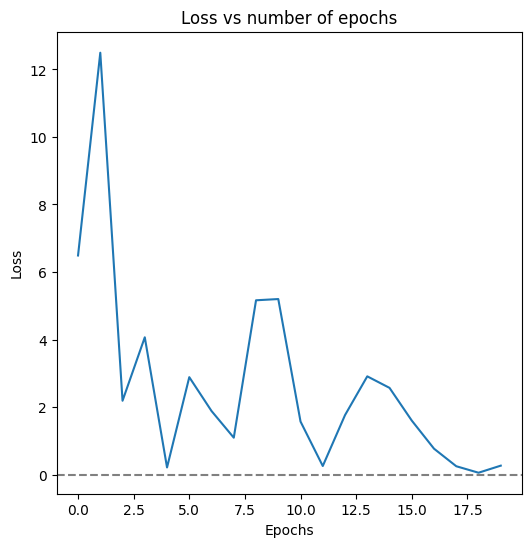

In [72]:
plt.figure(figsize=(6,6))
plt.plot(TOTAL_LOSS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(0.0, c='gray', linestyle='--')
plt.title('Loss vs number of epochs')
plt.show()

### 5. Testing the neural network.

In [73]:
N_test = 25

In [74]:
X_test = torch.linspace(0, L, N_test).view(-1, 1)
v_test = torch.linspace(-6, 6, N_test).view(-1, 1)
t_test = torch.linspace(0, 25, N_test).view(-1, 1)

X_test, v_test, t_test = torch.meshgrid(X_test.squeeze(), v_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
v_test = v_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)
print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape} and v_test : {v_test.shape}")

Shape of X_test : torch.Size([15625, 1]) and t_test : torch.Size([15625, 1]) and v_test : torch.Size([15625, 1])


In [75]:
model.eval()
with torch.no_grad():
  q_pred, e_pred = model(X_test, v_test, t_test)

In [76]:
q_pred = q_pred.reshape(N_test, N_test, N_test)
e_pred = e_pred.reshape(N_test, N_test, N_test)
X_test = X_test.reshape(N_test, N_test, N_test)
v_test = v_test.reshape(N_test, N_test, N_test)
t_test = t_test.reshape(N_test, N_test, N_test)

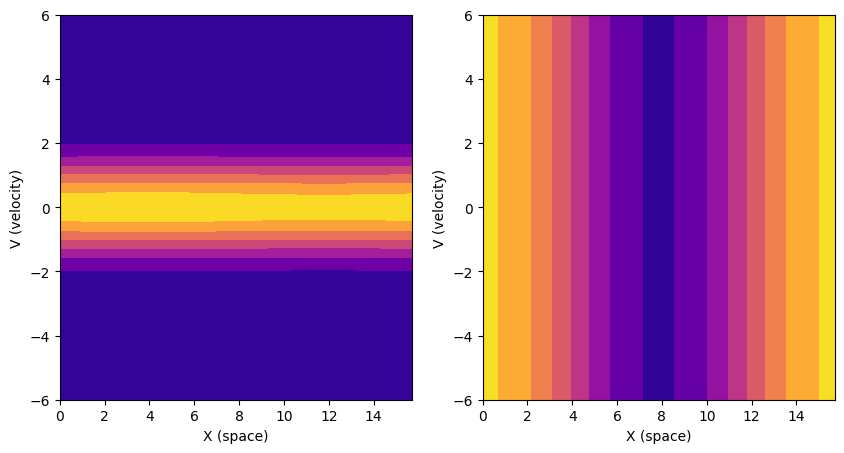

In [77]:
# Initial conditions are defined here just to see what's going on.

alpha = 0.01
initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v_test**2)/2))  * (1 + alpha * torch.sin(k * X_test))      #No use of v or t here, this is the initial condition.
initial_condition_E = (alpha/k) * torch.cos(k * X_test)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], cmap='plasma')
ax[0].set_xlabel('X (space)')
ax[0].set_ylabel('V (velocity)')


ax[1].contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_E[:, :, 0], cmap='plasma')
ax[1].set_xlabel('X (space)')
ax[1].set_ylabel('V (velocity)')

plt.show()

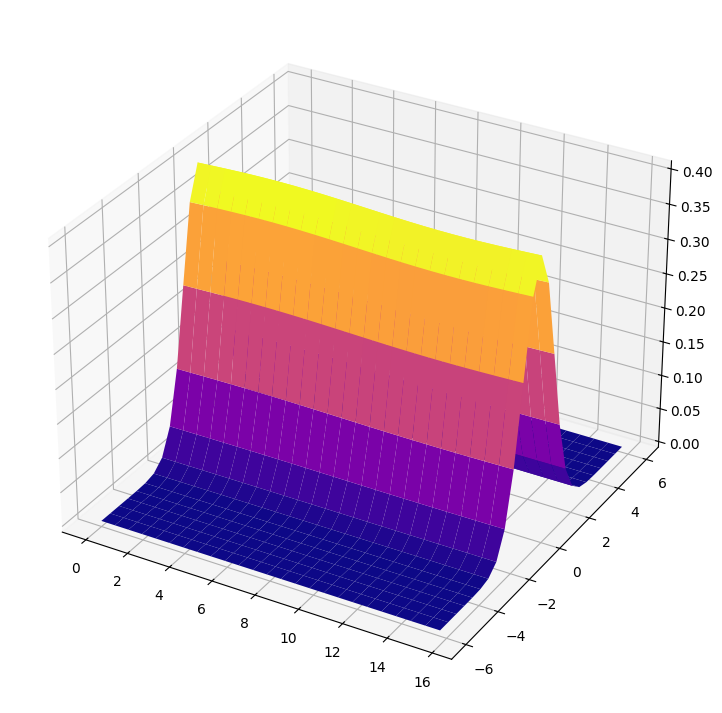

In [78]:
# Surface plot of initial condition

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], cmap='plasma')

# show plot
plt.show()

In [79]:
q_pred = q_pred.numpy()
e_pred = e_pred.numpy()
X_test = X_test.numpy()
v_test = v_test.numpy()
t_test = t_test.numpy()

In [80]:
print(f"Shape of q_pred, e_pred, x_test, v_test, t_test is {q_pred.shape}, {e_pred.shape}, {X_test.shape}, {v_test.shape} and {t_test.shape}")

Shape of q_pred, e_pred, x_test, v_test, t_test is (25, 25, 25), (25, 25, 25), (25, 25, 25), (25, 25, 25) and (25, 25, 25)


In [81]:
time_slice = 0

x_slice = X_test[:, :, time_slice]
v_slice = v_test[:, :, time_slice]
q_slice = q_pred[:, :, time_slice]
e_slice = e_pred[:, :, time_slice]

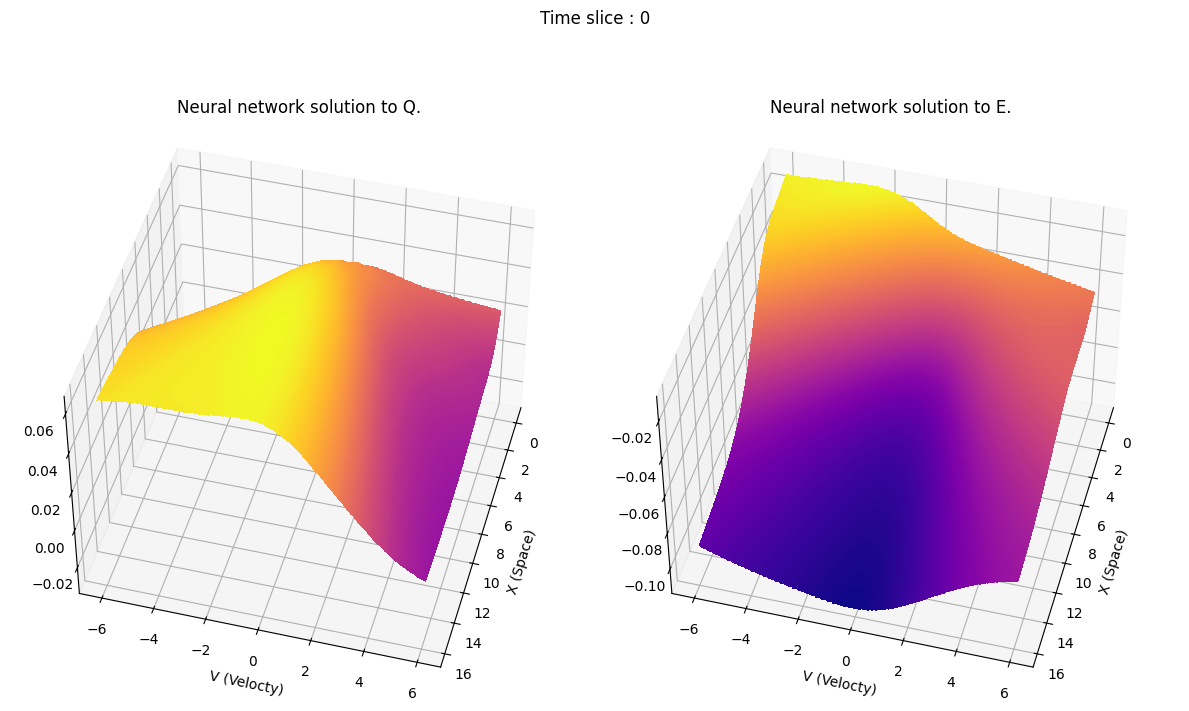

In [82]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.contourf(x_slice, v_slice, q_slice, levels=250, cmap='plasma')
ax1.set_xlabel('X (Space)')
ax1.set_ylabel('V (Velocty)')
ax1.set_title('Neural network solution to Q.')
ax1.view_init(elev=45, azim=15)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.contourf(x_slice, v_slice, e_slice, levels=250, cmap='plasma')
ax2.set_xlabel('X (Space)')
ax2.set_ylabel('V (Velocty)')
ax2.set_title('Neural network solution to E.')
ax2.view_init(elev=45, azim=15)

plt.suptitle(f"Time slice : {time_slice}")
plt.tight_layout()
plt.show()

In [83]:
  e_slice = e_pred[0, 0, :]
t_slice = t_test[0, 0, :]
print("Shape of e and t is : ", e_slice.shape, t_slice.shape)

Shape of e and t is :  (25,) (25,)


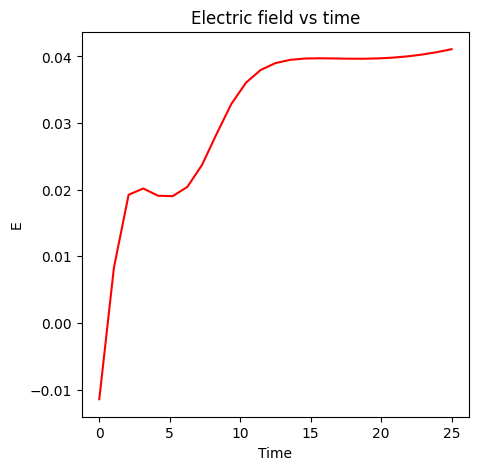

In [84]:
plt.figure(figsize=(5,5))
plt.plot(t_slice, e_slice, c='r')
plt.xlabel('Time')
plt.ylabel('E')
plt.title('Electric field vs time')
plt.show()